In [8]:
# Initialization

import os

use_gdrive, use_git, use_local = False, True, False

use_colab = 'COLAB_GPU' in os.environ

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')
  # Change with your drive "media" folder
  !ln -s "/content/drive/MyDrive/MyTeaching/Elaborazione-Audio-Digitale/EAD26_docente/EAD-U05.analisi-audio-tempo-frequenza/media" media
if use_git:
  if use_colab:
    !git clone "https://github.com/polito-EAD-2026/EAD26-U05.analisi-audio-tempo-frequenza.git"
    !mv ./EAD26-U05.analisi-audio-tempo-frequenza/* .
  else:
    import subprocess
    subprocess.run(['git', 'clone', "https://github.com/polito-EAD-2026/EAD26-U05.analisi-audio-tempo-frequenza.git"])
    subprocess.run(['mv', './EAD26-U05.analisi-audio-tempo-frequenza/*', '.'])

fatal: destination path 'EAD26-U05.analisi-audio-tempo-frequenza' already exists and is not an empty directory.
mv: cannot stat './EAD26-U05.analisi-audio-tempo-frequenza/*': No such file or directory


In [9]:
# Install Librosa
!pip install -q "librosa"

In [10]:
import librosa
import librosa.display
import soundfile as sf

import numpy as np
import scipy
from scipy import signal


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})

import IPython
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pprint import pprint

np.set_printoptions(suppress=True)



In [11]:
import matplotlib.pyplot as plt

"""
Example of usage:
import numpy as np
N, Fs, A, f = 10, 10, 0.5, 2
t = np.arange(N) / Fs
s = A * np.cos(2 * np.pi * f * t)
plot_vs_time(s,t, fmt='-*')
"""

def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-'):
    """
    Plots a waveform versus time using matplotlib.
    Parameters:
        w (array-like): The waveform data to plot (y-axis values).
        t (array-like): The time values corresponding to the waveform (x-axis values).
        xlim (tuple, optional): Limits for the x-axis as (min, max). If None, uses the range of t.
        ylim (list or tuple, optional): Limits for the y-axis as [min, max]. Defaults to [-1, +1].
        fig (matplotlib.figure.Figure, optional): Existing figure to plot on. If None, creates a new figure.
        fmt (str, optional): Format string for the plot line (e.g., '-', '--', 'o'). Defaults to '-'.
    Returns:
        tuple: (fig, ax) where fig is the matplotlib Figure object and ax is the Axes object.
    Notes:
        - The function sets axis labels, grid, and tight layout for better appearance.
        - If no figure is provided, a new figure with size (12, 3) is created.
    """
    fig, ax = plt.subplots(figsize=(12,3)) if fig is None else fig
    ax.plot(t,w,fmt)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(xlim) if xlim is not None else plt.xlim(t[0],t[-1])
    ax.set_ylim(ylim) if ylim is not None else None
    fig.tight_layout()
    ax.grid(visible=True)

import numpy as np
import matplotlib.pyplot as plt

# plot frequency spectrum
def plot_vs_freq(X, f, Fs, type="linear", xlim=None, ylim=None, fig=None, zp=False, fmt="-"):

  fig, ax = plt.subplots(figsize=(6,3)) if fig is None else fig
  xlim = [np.min(f), np.max(f)] if xlim is None else xlim

  if type == "linear":
    ax.set_ylabel('Magnitude')
    ylim = [0, 1.2] if ylim is None else ylim
    X = X
  elif type == "log":
    ax.set_ylabel('Power (dBFS)')
    ylim = [-60, +6] if ylim is None else ylim
    X = 10*np.log10(X**2)

  ax.plot(f, X, fmt)
  ax.set_xlabel('Frequency (Hz)')

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plt.grid(visible=True);
  plt.tight_layout()

# plot_vs_freq(x, Fs, N)
# plot_vs_freq(x, Fs, N, xlim=[2, 5], ylim=[-10, 3])

import numpy as np

def dft(x, Fs, N=None):
  L = len(x)
  N = L if N is None else N
  X = np.fft.rfft(x, N)
  X_ = np.abs(X) / (L/2)
  freq = np.fft.rfftfreq(N, d=1./Fs)
  # X_ = X_[:N//2+1]
  # freq = freq[:N//2+1]
  # X_dBFS = 20*np.log10(X_)
  return X_, freq

def normalize(x):
  return x / np.max(np.abs(x))

def RMS(x):
  return np.sqrt(np.mean(x**2))

def dBFS(x):
  return 20*np.log10(RMS(x)+np.finfo(float).eps)

# Analisi a "breve termine"

In [12]:

def pad_to_multiple(array, multiple):
  length = len(array)
  target = ((length + multiple - 1) // multiple) * multiple
  return np.pad(array, (0, target - length), mode='constant')

def time_framing_fn(x, L, H, win=None, fn=np.max):

  win = signal.windows.boxcar(L) if win is None else win # rectangular y = pad_to_multiple(x,L)
  y = pad_to_multiple(x,L)

  i_v = np.arange(0, len(y) - L+1, H) # index of first sample of each frame (check last)
  # print(f"Last frame starts at {i_v[-1]} and ends at {i_v[-1]+L}. Input has length {len(y)}")

  n_frames = len(i_v) # number of frames

  # ---- allocate output by probing fn on the first frame ----
  first_frame = y[0:L] * win
  test_val = fn(first_frame)
  out_shape = np.shape(test_val)
  fn_v = np.zeros((n_frames,) + out_shape)
  # ----

  for n in range(n_frames):
    i = i_v[n]
    frame = y[ i : i+L ]
    frame_w = frame * win # windowed frame
    fn_v[n] = fn(frame_w)

  return (i_v, fn_v)


def round_to_even(x):
    return int(2 * round(x / 2))

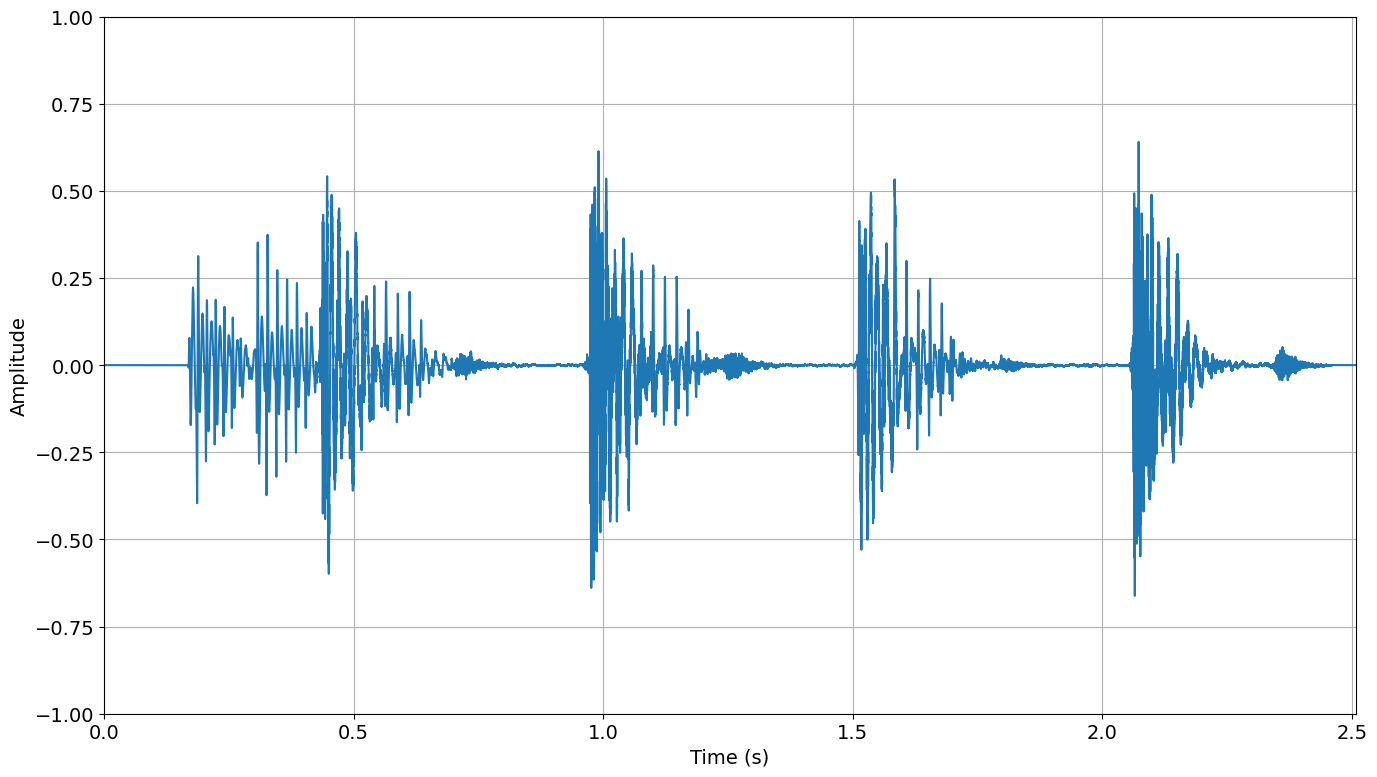

In [13]:
filename = '/content/media/queen-onset.wav'
y, Fs = librosa.load(filename, sr=None)

fig, ax = plt.subplots(figsize=(14,8))
t = np.arange(0,len(y))/Fs
# def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-'):
plot_vs_time(y, t, fig=(fig,ax))

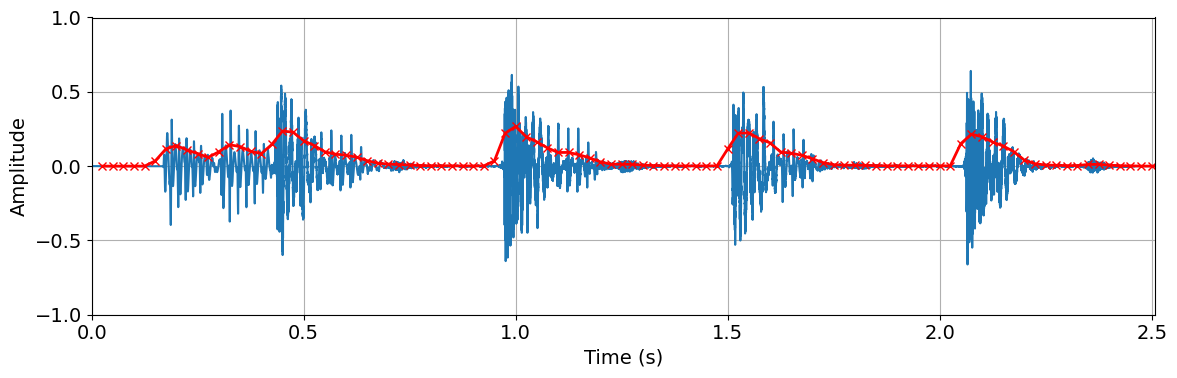

In [14]:
from scipy import signal


filename = '/content/media/queen-onset.wav'
y, Fs = librosa.load(filename, sr=None)

fig, ax = plt.subplots(figsize=(12,4))
t = np.arange(0,len(y))/Fs
plot_vs_time(y, t, fig=(fig,ax))

R = 20 # rate per seconds
L = round_to_even(Fs/R) # use even number for L
H = L//2

# LUFS-M
# L, H = int(Fs/1000*400), int(Fs/1000*100)

idxs, vals = time_framing_fn(y, L, H, win=None, fn=RMS)
ax.plot((idxs+L/2)/Fs, vals, '-xr', linewidth=2)

# idxs, vals = time_framing_fn(y, L, H, win=None, fn=np.min)
# ax.plot((idxs+L/2)/Fs, vals, '-xg', linewidth=2)

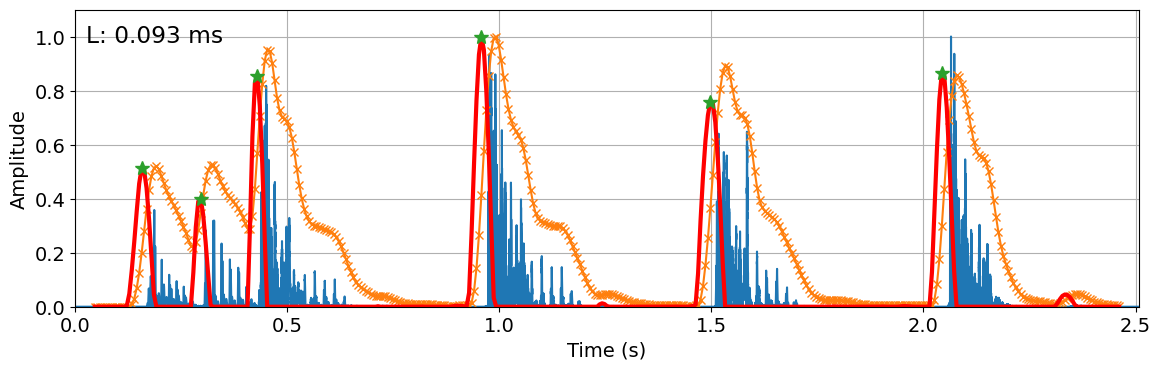

In [15]:
def log_g(x,g):
  return np.log(1 + g * x)

feat_rms = True
feat_rms_log = False

filename = '/content/media/queen-onset.wav'
y, Fs = librosa.load(filename, sr=None)
y = normalize(y)
t = np.arange(0,len(y))/Fs
dur = len(y) / Fs

fig, ax1 = plt.subplots(figsize=(12,4))
plot_vs_time( y**2, t, fig=(fig,ax1)) # , alpha=0.5)

L, H = 2048, 128
w = signal.windows.hann(L)

if feat_rms:
  idxs, vals = time_framing_fn(y, L, H, win=w, fn=lambda x: RMS(x))
elif feat_rms_log:
  idxs, vals = time_framing_fn(y, L, H, win=w, fn=lambda x: log_g(RMS(x),1000))

idxs = idxs + L/2

novelty_v = normalize(vals)
ax1.plot( idxs/Fs, novelty_v, '-x')

vals_diff = np.concatenate(( np.diff(vals), np.array([0]) ))
novelty_v = np.copy(vals_diff)
novelty_v[novelty_v < 0] = 0
novelty_v = normalize(novelty_v)
ax1.plot( idxs/Fs, novelty_v, '-r', linewidth=3)


peaks, properties = signal.find_peaks(novelty_v, prominence=0.05)
peaks_i = idxs[peaks]
ax1.plot(peaks_i/Fs, novelty_v[peaks], '*', ms=10)
# plt.vlines(peaks_i/Fs, -1, 1.1, color='r', linestyle=':', linewidth=3);

ax1.set_ylim(0,1.1)
ax1.set_xlim(0,dur)

ax1.set_title(f"L: {L/Fs:.2} ms", x=0.01, y=0.86, loc='left')

print()


# Analisi tempo/frequenza

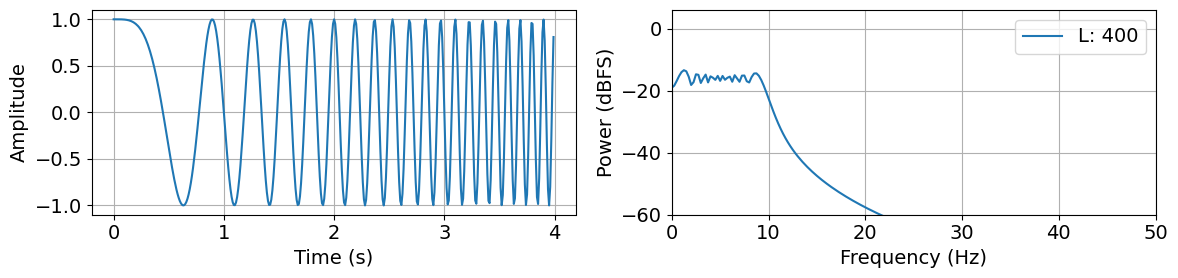

In [16]:
# Chirp

Fs = 100
dur = 4

t = np.arange(Fs*dur)/Fs
x = signal.chirp(t, f0=0, t1=4, f1=10, method='linear')

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,3))
plot_vs_time(x, t,  ylim = [-1.1, +1.1], fig=(fig,ax1), fmt='-')
X, f = dft(x, Fs)
plot_vs_freq(X, f, Fs, type="log", fig=(fig,ax2))

ax2.legend([f"L: {len(x)}"])
plt.show()

(33, 13)


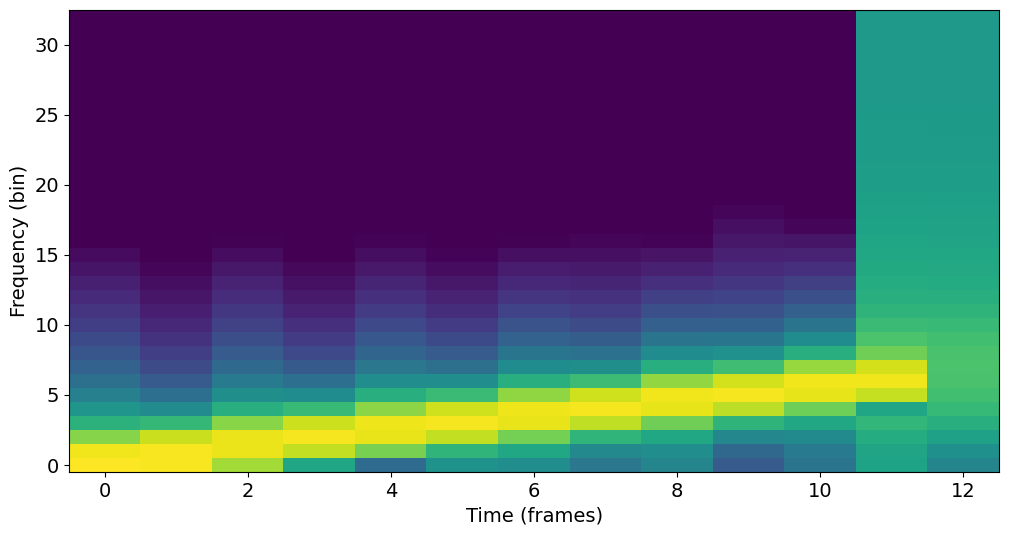

In [17]:

fig, ax = plt.subplots(figsize=(12,6))

L, H = 64, 32
N = 64
w = signal.windows.hann(L)
idxs, vals = time_framing_fn(x, L, H, win=w, fn=lambda x: dft(x,Fs,N))

# vals = [ (X0, freq0), (X1, freq1), (X2, freq2), ... ]
# get frequencies
Xf = np.array(vals[0][1])
# get spectrogram
Xv = np.array([v[0] for v in vals]).T
print(Xv.shape)

# adapt dBs to STFT computation +6 and 80 dB delta max
XvdB = 20*np.log10(Xv)+6
XvdB = np.maximum(XvdB, XvdB.max() - 80)

plt.imshow(XvdB, origin='lower', aspect='auto', cmap="viridis")
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (bin)')

plt.show()


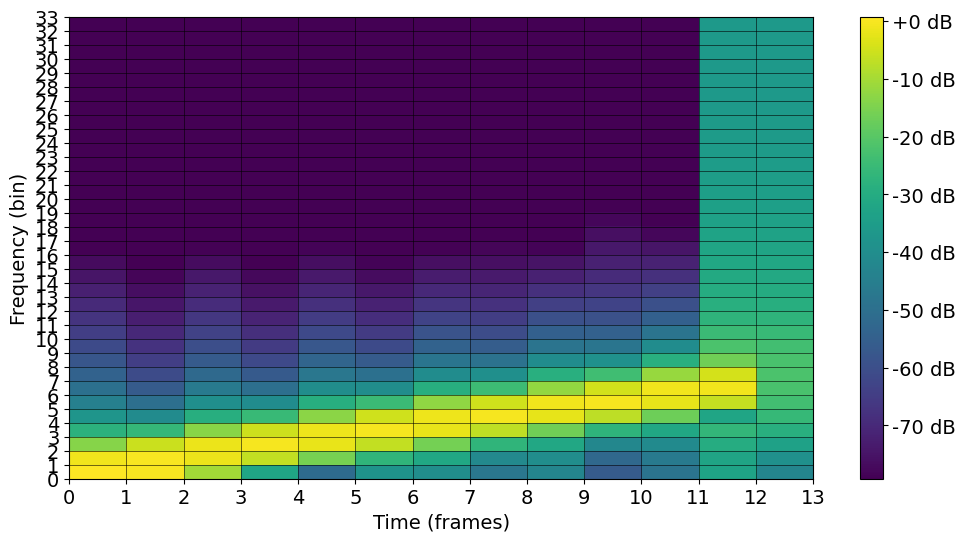

In [18]:
# SPECTROGRAM PLOT WITH COLORBAR AND GRID

fig, ax = plt.subplots(figsize=(12,6))
M = np.array(XvdB)  # matrice
n_rows, n_cols = M.shape

img = plt.imshow(M, origin='lower', aspect='auto', cmap="viridis", extent=[0, n_cols, 0, n_rows])  # <-- assegna i bordi reali
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (bin)')

# tick ai bordi delle celle, non al centro
plt.xticks(np.arange(0, n_cols + 1, 1))
plt.yticks(np.arange(0, n_rows + 1, 1))

# griglia sui bordi
plt.grid(color='black', linewidth=0.4)

# Aggiungi colorbar laterale
cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")

# cbar.set_label('Amplitude (dB)', rotation=90)

plt.show()

(33, 11)


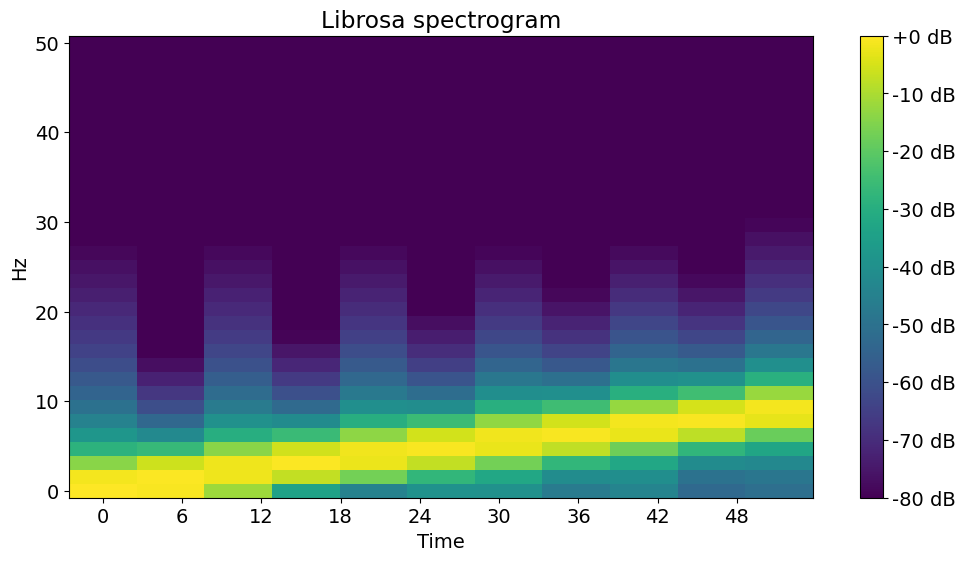

In [19]:
# LIBROSA SPECTROGRAM

# Compute STFT => returns complex valued spectrogram
y = pad_to_multiple(x,L)
S = librosa.stft(x, win_length=L, hop_length=H, n_fft=N, window='hann', center=False)
print(S.shape)

# Get amplitude spectrogram in dB where 0 dB correspond to max value
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Compute freq and time axes values
freqs = librosa.fft_frequencies(sr=Fs, n_fft=N)
times = librosa.frames_to_time(np.arange(S.shape[1]), sr=Fs, hop_length=H)

# Display spectrogram with librosa function specshow function

fig, ax = plt.subplots(figsize=(12,6))

img = librosa.display.specshow( S_db, sr=Fs, cmap="viridis", x_axis='time', y_axis='linear', ax=ax) # y_axis='log'

ax.set_title(f'Librosa spectrogram')
fig.colorbar(img, format="%+2.f dB")


(513, 213)


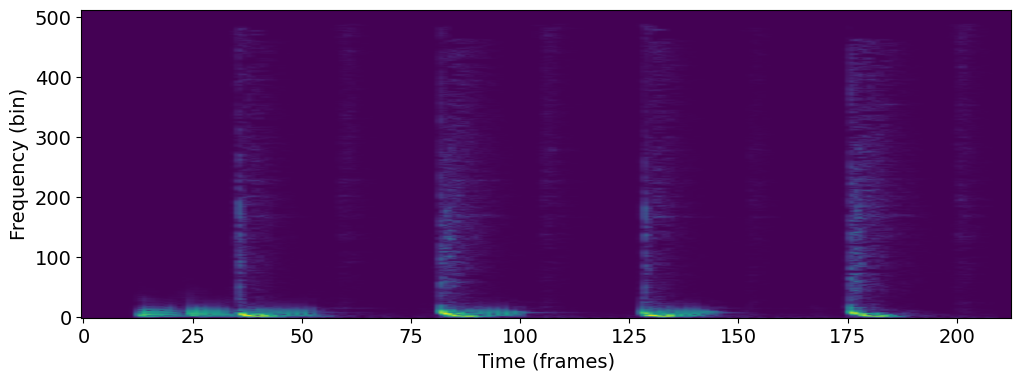

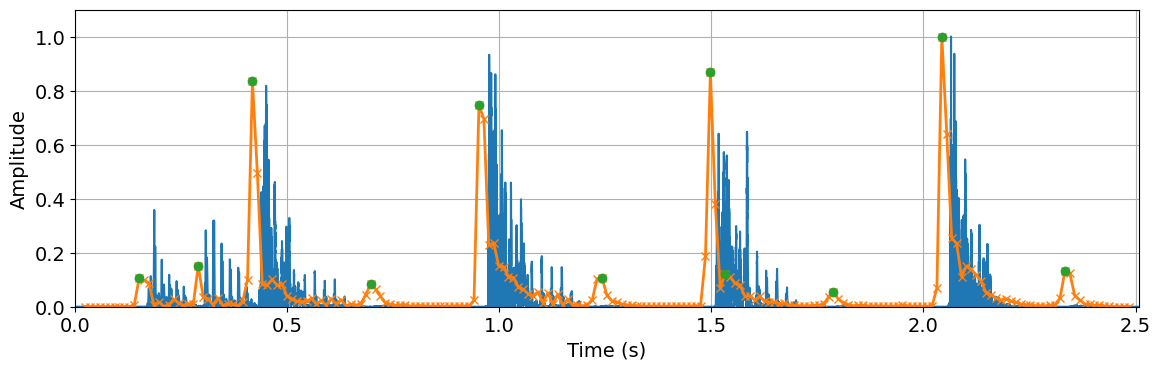

In [20]:

filename = '/content/media/queen-onset.wav'

y, Fs = librosa.load(filename, sr=None)
y = normalize(y)
t = np.arange(0,len(y))/Fs
dur = len(y) / Fs

L, H = 1024, 256
N = L
w = signal.windows.hann(L)
idxs, vals = time_framing_fn(y, L, H, win=w, fn=lambda x: dft(x,Fs,N))
Xf = np.array(vals[0][1])
Xv = np.array([v[0] for v in vals]).T
print(Xv.shape)
idxs = idxs + L//2

vals = log_g(Xv,100)
fig, ax1 = plt.subplots(figsize=(12,4))
plt.imshow(vals, origin='lower', aspect='auto', cmap="viridis")
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (bin)')
plt.show()


# vals_diff = np.concatenate(( np.diff(vals), np.array([0]) ))
novelty_v = np.diff(vals, n=1)
novelty_v[novelty_v < 0] = 0
novelty_v = np.sum(novelty_v, axis=0)
novelty_v = np.concatenate( (novelty_v, np.array([0])))
novelty_v = normalize(novelty_v)

peaks, properties = signal.find_peaks(novelty_v, prominence=0.05)

fig, ax1 = plt.subplots(figsize=(12,4))
plot_vs_time( y**2, t, fig=(fig,ax1)) # , alpha=0.5)
ax1.plot(idxs/Fs, novelty_v, '-x', linewidth=2)
ax1.plot(idxs[peaks]/Fs, novelty_v[peaks], 'o')
ax1.set_ylim(0,1.1)
ax1.set_xlim(0,dur)
plt.show()


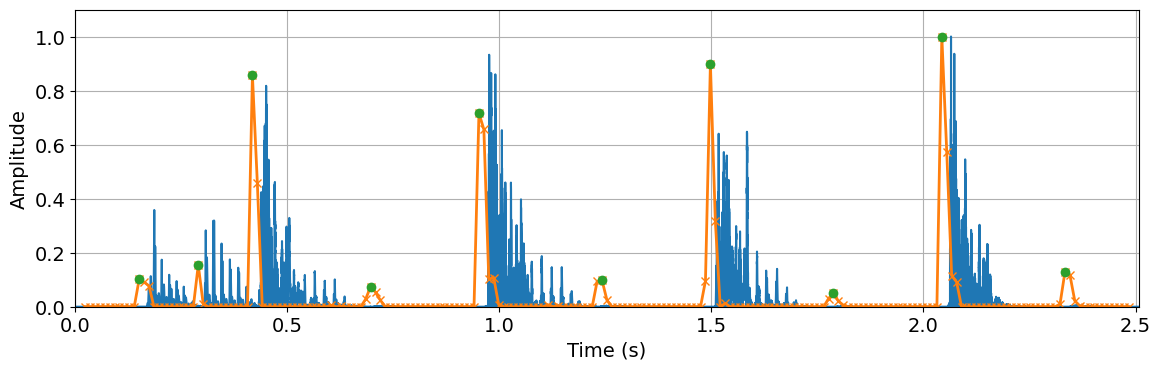

In [21]:
def compute_local_average(x, M):
    """Compute local average of signal

    Notebook: C6/C6S1_NoveltySpectral.ipynb

    Args:
        x (np.ndarray): Signal
        M (int): Determines size (2M+1) in samples of centric window  used for local average

    Returns:
        local_average (np.ndarray): Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

Fs_nov = Fs/H
M_sec = 0.1
M = int(np.ceil(M_sec * Fs_nov))

local_average = compute_local_average(novelty_v, M)
novelty_v =  novelty_v - local_average
novelty_v[novelty_v<0]=0
novelty_v = normalize(novelty_v)

peaks, properties = signal.find_peaks(novelty_v, prominence=0.03)

fig, ax1 = plt.subplots(figsize=(12,4))
plot_vs_time( y**2, t, fig=(fig,ax1)) # , alpha=0.5)
ax1.plot(idxs/Fs, novelty_v, '-x', linewidth=2)
ax1.plot(idxs[peaks]/Fs, novelty_v[peaks], 'o')
ax1.set_ylim(0,1.1)
ax1.set_xlim(0,dur)
plt.show()

In [ ]:
# Muller

import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
import librosa
from ipywidgets import interact, fixed, FloatSlider
import IPython.display as ipd
%matplotlib inline

Fs = 32
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(x)) / Fs
freq = np.fft.fftfreq(N, d=1/Fs)
X = X[:N//2]
freq = freq[:N//2]
plt.plot(freq, X, c='k')
plt.xlim([0, 7])
plt.ylim([0, 3])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

def windowed_ft(t, x, Fs, w_pos_sec, w_len):

    N = len(x)
    w_pos = int(Fs * w_pos_sec)
    w_padded = np.zeros(N)
    w_padded[w_pos:w_pos + w_len] = 1
    x = x * w_padded
    plt.figure(figsize=(8, 2))

    plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    plt.plot(t, w_padded, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (seconds)')

    plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

w_len = 4 * Fs
windowed_ft(t, x, Fs, w_pos_sec=1, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=3, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=5, w_len=w_len)


print('Interactive interface for experimenting with different window shifts:')
interact(windowed_ft,
         w_pos_sec=FloatSlider(min=0, max=duration-(w_len/Fs), step=0.1,
                continuous_update=False, value=1.7, description='Position'),
                t=fixed(t), x=fixed(x), Fs=fixed(Fs), w_len=fixed(w_len));


